In [1]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from matplotlib import image
from scipy.spatial.distance import cdist
from PIL import Image
from tqdm import tqdm
import pandas as pd
from scipy import ndimage
import cv2

In [ ]:
dataset_root = ""

# Generate Heatmaps

In [2]:
def gaussian(x, sx, y=None, sy=None):
    """Returns an array of np arrays (a matrix) containing values between
    1 and 0 in a 2D Gaussian distribution
    arguments
    x		-- width in pixels
    sx		-- width standard deviation
    keyword argments
    y		-- height in pixels (default = x)
    sy		-- height standard deviation (default = sx)
    """

    # square Gaussian if only x values are passed
    if y == None:
        y = x
    if sy == None:
        sy = sx
    # centers
    xo = x / 2
    yo = y / 2
    # matrix of zeros
    M = np.zeros([y, x], dtype=float)
    # gaussian matrix
    for i in range(x):
        for j in range(y):
            M[j, i] = np.exp(-1.0 * (((float(i) - xo) ** 2 / (2 * sx * sx)) + ((float(j) - yo) ** 2 / (2 * sy * sy))))

    return M


def normalize_map(s_map):
    norm_s_map = (s_map - np.min(s_map)) / ((np.max(s_map) - np.min(s_map)) * 1.0)
    return norm_s_map


def draw_heatmap(normed_gazepoints, originalsize, org_img_size=(768, 768)):
    heatmap = np.zeros(org_img_size, dtype=np.float32)

    for p in normed_gazepoints:
        x = round(p[0] * org_img_size[1]) - 1
        y = round(p[1] * org_img_size[0]) - 1

        # heatmap[y, x] += p[2]
        heatmap[y, x] += 1

    heatmap = ndimage.filters.gaussian_filter(heatmap, 70)
    heatmap = normalize_map(heatmap)
    heatmap = cv2.resize(heatmap, dsize=(originalsize[1], originalsize[0]), interpolation=cv2.INTER_CUBIC)

    return heatmap.astype(np.float16)

In [4]:
df_gaze_filtered = pd.read_csv("../gaze/fixation_preprocessed.csv")
df_imgs = pd.read_csv("../gaze/exp_resources/all_exp_list.csv")

dice_l = {}

target = 424

for i, (name, group) in tqdm(enumerate(df_gaze_filtered.groupby("images"))):
    img_file = group["images"].tolist()[0]

    org_img_size = tuple(df_imgs.loc[df_imgs["images"] == img_file][["org_img_height", "org_img_width"]].values[0])

    gaze_list = np.array(
        df_gaze_filtered.loc[
            df_gaze_filtered["images"] == img_file,
            ["CURRENT_FIX_X", "CURRENT_FIX_Y", "CURRENT_FIX_DURATION"],
        ]
    )
    heatmap = draw_heatmap(gaze_list, org_img_size)

    img = Image.open(os.path.join("../images", img_file))
    gt = Image.open(os.path.join("../masks", img_file)).convert("L")

    gt_array = np.array(gt) / 255

    dice = compute_dice(heatmap, gt_array)
    dice_l[name] = dice

    save_folder = os.path.join("../", "gaze", "heatmap_new")
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    heatmap_img = Image.fromarray((heatmap * 255).astype(np.uint8))
    heatmap_img.save(os.path.join(save_folder, img_file))

    # np.save(os.path.join(save_folder, img_file.replace(".jpg", ".npy")), heatmap)

1000it [07:06,  2.35it/s]


In [6]:
# 0.4451447479749784

print(np.mean(list(dice_l.values())))

0.4402005889682506


In [32]:
ab_count = 0

for k, v in dice_l.items():
    if v < 0.1:
        ab_count += 1
        print(k)

print(ab_count)

cju0qkwl35piu0993l0dewei2.jpg
cju0qoxqj9q6s0835b43399p4.jpg
cju0qx73cjw570799j4n5cjze.jpg
cju0s2a9ekvms080138tjjpxr.jpg
cju0sr5ghl0nd08789uzf1raf.jpg
cju0t4oil7vzk099370nun5h9.jpg
cju0tl3uz8blh0993wxvn7ly3.jpg
cju0u2g7pmnux0801vkk47ivj.jpg
cju0u82z3cuma0835wlxrnrjv.jpg
cju15czxqp3lv0835jvhgzurz.jpg
cju15jr8jz8sb0855ukmkswkz.jpg
cju16whaj0e7n0855q7b6cjkm.jpg
cju171py4qiha0835u8sl59ds.jpg
cju17g6ykn1cs0993dww6qdi8.jpg
cju17otoe119u0799nqcbl8n1.jpg
cju17v6ih0u7808783zcbg1jy.jpg
cju17x0j4nfc10993y31pvlgs.jpg
cju1c0qb4tzi308355wtsnp0y.jpg
cju1dfeupuzlw0835gnxip369.jpg
cju1drnhbrb9409935wi7vkhg.jpg
cju1expq45zst0855rjqwwj4m.jpg
cju1fb9236a110801yvg0fwju.jpg
cju1fr4etsmrr09933u4t4aql.jpg
cju1g20bdwq6u0835e16xugcd.jpg
cju1hmff8tkp809931jps6fbr.jpg
cju1hyolc7aqu0878rrkfn1lr.jpg
cju2hw5gjlr5h0988so2qqres.jpg
cju2i3hzclw3o0988rrgh911i.jpg
cju2igw4gvxds0878808qj398.jpg
cju2nd7l7z98o0799gfjvyfmw.jpg
cju2nnqrqzp580855z8mhzgd6.jpg
cju2oi8sq0i2y0801mektzvw8.jpg
cju2okvco06xc0799kxe5n1qh.jpg
cju2omjpeq

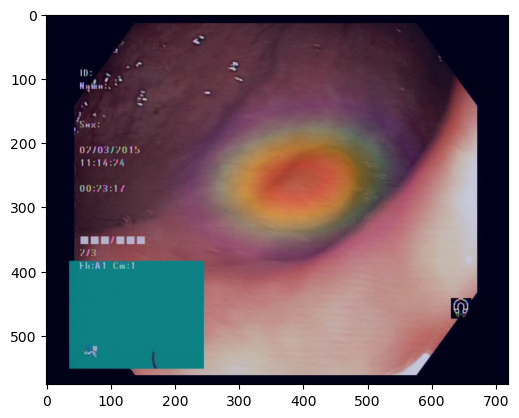

In [7]:
plt.imshow(img)
plt.imshow(heatmap, alpha=0.2, cmap="jet")
# plt.scatter(gaze_list[:, 0] * org_img_size[1], gaze_list[:, 1] * org_img_size[0], s=gaze_list[:, 2], alpha=0.7)
# for i in range(gaze_data_h.shape[0]):
#     plt.annotate(str(i + 1), (gaze_data_h[i, 0], gaze_data_h[i, 1]))